Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [2]:
from random import random, seed
from itertools import accumulate
from icecream import ic
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [3]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [4]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [5]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [6]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(4279765.971731415))

In [7]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(2139499.3304957775))

UTILS

In [16]:
# function to print fitness graph
def print_fitness_history(history: list, history_valid_sol: list):
    mask = np.array(history_valid_sol) > -float('inf')
    x = np.arange(len(history_valid_sol))[mask]
    y = np.array(history_valid_sol)[mask]
    plt.figure(figsize=(14,8))
    plt.scatter(range(len(history)), history, marker=".")
    plt.plot(
    x,
    list(accumulate(y, max)),
    color = "red"
    )

FITNESS

In [9]:
# use as fitness the solution validity (bool) and -cost
def fitness_by_validity(solution: np.ndarray) -> tuple[bool, float]:
    return (int(valid(solution)), float(-cost(solution)))

# use as fitness the covered items of the universe and -cost
def fitness_by_takenItems(solution: np.ndarray) -> tuple[int, float]:
    taken_items = int(np.sum(np.any(SETS[solution,:], axis=0)))
    return (taken_items, float(-cost(solution)))

MUTATION FUNCTIONS

In [10]:
def single_mutation(solution: np.ndarray) -> np.ndarray:
    temp = solution.copy()
    idx = rng.integers(NUM_SETS)
    temp[idx] = not temp[idx]
    return temp

def single_mutation_iterative(solution: np.ndarray) -> np.ndarray:
    temp = solution.copy()
    idx = None
    while idx is None or np.random.random() < 0.5:
        idx = rng.integers(NUM_SETS)
        temp[idx] = not temp[idx]
    return temp

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    mask = rng.random(NUM_SETS) < 0.01
    temp = np.logical_xor(solution, mask)
    return temp

<h3>SIMULATED ANNEALING HILL CLIMBING<h3>

In [11]:
# function to evaluate f(s) - f(s') aka cost difference
# if the solution is invalid or dont cover all the universe size (based on the fitness chosed) assign a penalty to the cost
def evaluate_cost_diff(fitness: tuple[int, float], new_fitness: tuple[int, float], fitness_function_name) -> float:
    cost_diff = new_fitness[1] - fitness[1]
    items_diff = fitness[0] - new_fitness[0]
    return cost_diff if items_diff == 0 else cost_diff - (10000. if fitness_function_name == 'fitness_by_takenItems' else 1) * items_diff

In [12]:
NUM_STEPS = 10000
DECREASING_RATE = 0.9 # for the temperature
MAX_WORSENING_SOL = 10 # after n consecutive worst solution the temperature is increased

def set_cover_sahc(solution: np.ndarray, fitness_function, tweak):
    
    fitness = fitness_function(solution)
    best_solution = solution
    best_fitness = fitness
    ic(fitness)
    temperature = UNIVERSE_SIZE
    history = [fitness[1]]
    history_valid_sol = [-float('inf')]
    worst_fitness_counter = 0

    for _ in tqdm(range(NUM_STEPS)):
        new_sol = tweak(solution)
        new_fitness = fitness_function(new_sol)
        history.append(new_fitness[1])
        solution_invalid = 1 # only for better print the valid solution

        cost_diff = evaluate_cost_diff(fitness, new_fitness, fitness_function.__name__)
        p = float(np.exp(cost_diff/temperature))
        temperature *= DECREASING_RATE
        
        if fitness >= new_fitness:
            worst_fitness_counter += 1
        else:
            worst_fitness_counter = 0

        if worst_fitness_counter > MAX_WORSENING_SOL:
            temperature = temperature * 1.1

        if rng.random() < p:
            if new_fitness[0] == (UNIVERSE_SIZE if fitness_function.__name__ == 'fitness_by_takenItems' else True):
                solution_invalid = 0
                best_solution = new_sol
                best_fitness = new_fitness
                history_valid_sol.append(new_fitness[1])
            solution = new_sol
            fitness = new_fitness
        
        if solution_invalid and len(history_valid_sol) > 0:
            history_valid_sol.append(history_valid_sol[-1])

    return (best_solution, best_fitness, history, history_valid_sol)

ic| fitness: (3594, -8572.924520341174)


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_145586/2060425035.py:23: RuntimeWarning: overflow encountered in exp
  p = float(np.exp(cost_diff/temperature))
ic| final_fitness: (10000, -133263.07326203023)
ic| x[-1]: np.int64(10000)


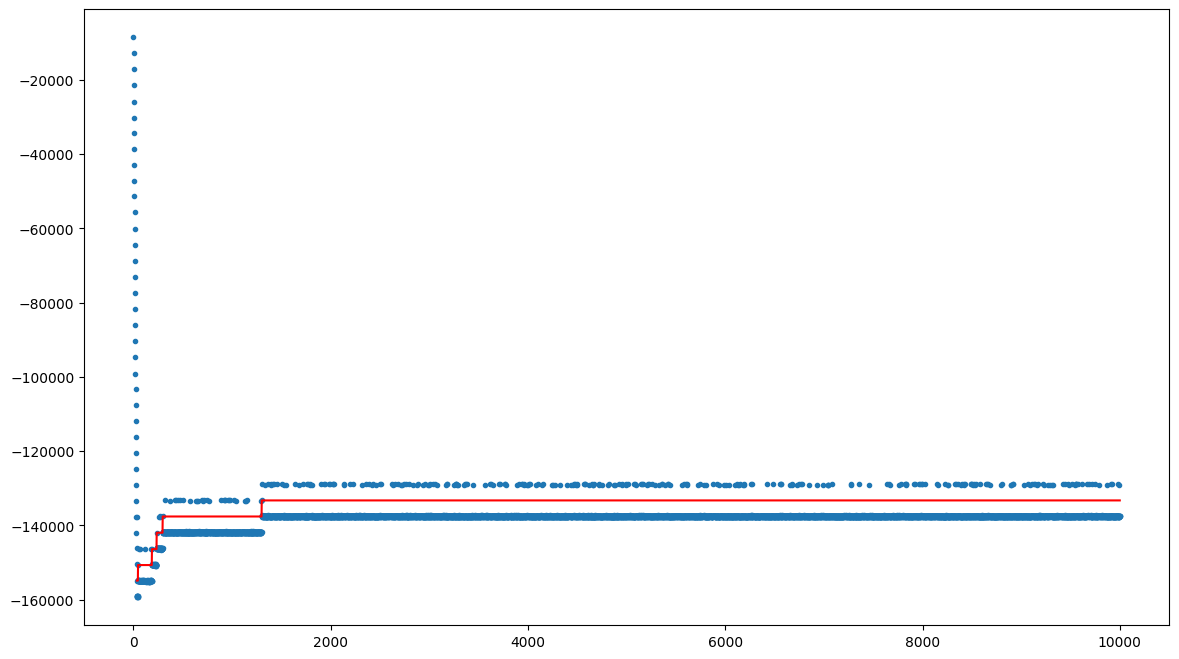

In [13]:
# init_solution = np.full(NUM_SETS, True)
# init_solution = np.full(NUM_SETS, False)
init_solution = rng.random(NUM_SETS) < .001

final_solution, final_fitness, history, history_valid_sol = set_cover_sahc(init_solution, fitness_by_takenItems, single_mutation)

ic(final_fitness)

print_fitness_history(history, history_valid_sol)
